<center>

# 重新认识矩阵乘法运算

</center>

The *foundations* we'll assume throughout this course are:

- Python
- Python modules (non-DL)
- Numpy

- 资源： 
1. [Matrix 演示网站](http://matrixmultiplication.xyz/)

## Check imports

In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [218]:
print(np.__version__)

1.16.4


## 先从输入数据说起

In [97]:
img = np.array([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0117,
        0.0703, 0.0703, 0.0703, 0.4922, 0.5312, 0.6836, 0.1016, 0.6484, 0.9961,
        0.9648, 0.4961, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1172, 0.1406, 0.3672, 0.6016,
        0.6641, 0.9883, 0.9883, 0.9883, 0.9883, 0.9883, 0.8789, 0.6719, 0.9883,
        0.9453, 0.7617, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1914, 0.9297, 0.9883, 0.9883,
        0.9883, 0.9883, 0.9883, 0.9883, 0.9883, 0.9883, 0.9805, 0.3633, 0.3203,
        0.3203, 0.2188, 0.1523, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0703, 0.8555, 0.9883,
        0.9883, 0.9883, 0.9883, 0.9883, 0.7734, 0.7109, 0.9648, 0.9414, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3125,
        0.6094, 0.4180, 0.9883, 0.9883, 0.8008, 0.0430, 0.0000, 0.1680, 0.6016,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0547, 0.0039, 0.6016, 0.9883, 0.3516, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.5430, 0.9883, 0.7422, 0.0078, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0430, 0.7422, 0.9883, 0.2734,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1367, 0.9414,
        0.8789, 0.6250, 0.4219, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3164, 0.9375, 0.9883, 0.9883, 0.4648, 0.0977, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1758, 0.7266, 0.9883, 0.9883, 0.5859, 0.1055, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0625, 0.3633, 0.9844, 0.9883, 0.7305,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9727, 0.9883,
        0.9727, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1797, 0.5078, 0.7148, 0.9883,
        0.9883, 0.8086, 0.0078, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.1523, 0.5781, 0.8945, 0.9883, 0.9883,
        0.9883, 0.9766, 0.7109, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0938, 0.4453, 0.8633, 0.9883, 0.9883, 0.9883,
        0.9883, 0.7852, 0.3047, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0898, 0.2578, 0.8320, 0.9883, 0.9883, 0.9883, 0.9883,
        0.7734, 0.3164, 0.0078, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0703, 0.6680, 0.8555, 0.9883, 0.9883, 0.9883, 0.9883, 0.7617,
        0.3125, 0.0352, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2148, 0.6719, 0.8828, 0.9883, 0.9883, 0.9883, 0.9883, 0.9531, 0.5195,
        0.0430, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.5312, 0.9883, 0.9883, 0.9883, 0.8281, 0.5273, 0.5156, 0.0625,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])

In [98]:
img.shape

(784,)

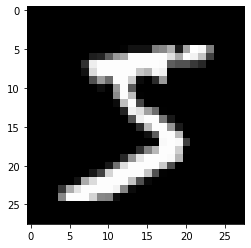

In [101]:
plt.imshow(img.reshape(28,28))

In [102]:
# 构造一个有5万个样本的数据集
img = np.expand_dims(img, axis=0)
x_train = np.repeat(img, 50000, axis=0)
x_train.shape

(50000, 784)

In [103]:
M = x_train.shape[1]

In [105]:
C = 10

## 构建神经网络的基本单元：权重与偏置

In [106]:
weights = np.random.randn(M, C)

In [107]:
bias = np.zeros(C)

#### Matrix multiplication

1. 三重循环方案

In [148]:
def matmul(a,b):
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    assert ac==br
    c = np.zeros((ar,bc))
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): # or br
                c[i,j] += a[i,k] * b[k,j]
    return c

In [149]:
m1 = x_train[:5]
m2 = weights

In [110]:
m1.shape,m2.shape

((5, 784), (784, 10))

In [150]:
%time t1=matmul(m1, m2)

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 26.6 ms


In [121]:
t1.shape

(5, 10)

This is kinda slow - what if we could speed it up by 50,000 times? Let's try!

In [122]:
len(x_train)

50000

> 如果处理全部数据，一个矩阵运算的时间 10000 *  28ms = ?

#### Elementwise ops

Operators (+,-,\*,/,>,<,==) are usually element-wise.

Examples of element-wise operations:

In [126]:
a = np.array([10., 6, -4])
b = np.array([2., 8, 7])
a,b

(array([10.,  6., -4.]), array([2., 8., 7.]))

In [127]:
a + b

array([12., 14.,  3.])

In [129]:
(a < b).mean()

0.6666666666666666

In [130]:
m = np.array([[1., 2, 3], [4,5,6], [7,8,9]]); m

array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]])

Frobenius norm:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$


In [131]:
np.sqrt(np.square(m).sum())

16.881943016134134

#### Elementwise matmul

In [153]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = np.zeros((ar, bc))
    for i in range(ar):
        for j in range(bc):
            # Any trailing ",:" can be removed
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [139]:
%timeit -n 10 _=matmul(m1, m2)

519 µs ± 22.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [134]:
28*1000/596

46.97986577181208

In [135]:
#export
def near(a,b): return np.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

In [154]:
test_near(t1,matmul(m1,m2))

### Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

#### Broadcasting with a scalar

In [155]:
a

array([10.,  6., -4.])

In [156]:
a > 0

array([ True,  True, False])

How are we able to do a > 0?  0 is being **broadcast** to have the same dimensions as a.

For instance you can normalize our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar), using broadcasting.

Other examples of broadcasting with a scalar:

In [157]:
a + 1

array([11.,  7., -3.])

- rank = 2 ?

In [158]:
m

array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]])

In [159]:
2*m

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

#### Broadcasting a vector to a matrix

![](https://jakevdp.github.io/PythonDataScienceHandbook/figures/02.05-broadcasting.png)

We can also broadcast a vector to a matrix:

In [160]:
c = np.array([10.,20,30]); c

array([10., 20., 30.])

In [161]:
m

array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]])

In [162]:
m.shape,c.shape

((3, 3), (3,))

In [163]:
m + c

array([[11., 22., 33.],
       [14., 25., 36.],
       [17., 28., 39.]])

In [164]:
c + m

array([[11., 22., 33.],
       [14., 25., 36.],
       [17., 28., 39.]])

In [165]:
m + c == c + m 

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

We don't really copy the rows, but it looks as if we did. In fact, the rows are given a *stride* of 0.

#### 以下代码通过pytorch的tensor测试
`***************************************************************************`

In [170]:
from torch import tensor
m0 = torch.from_numpy(m)
c0 = torch.from_numpy(c)
t = c0.expand_as(m0)

In [50]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [51]:
t.shape

torch.Size([3, 3])

In [52]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [53]:
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [217]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

> 解释 `stride()`, row to row ，步长为0， column to column 步长为1

测试完成

`*****************************************************************************************************`

In [223]:
m.strides

(24, 8)

In [210]:
c.shape, c[None].shape,c[:,None].shape

((3,), (1, 3), (3, 1))

You can always skip trailling ':'s. And '...' means '*all preceding dimensions*'

- or use `np.newaxis`

In [211]:
c[None].shape,c[...,None].shape

((1, 3), (3, 1))

In [213]:
m + c[:,None]

array([[11., 12., 13.],
       [24., 25., 26.],
       [37., 38., 39.]])

In [214]:
m + c[:,None] - m

array([[10., 10., 10.],
       [20., 20., 20.],
       [30., 30., 30.]])

In [215]:
c[:,None]

array([[10.],
       [20.],
       [30.]])

In [216]:
c

array([10., 20., 30.])

In [175]:
c[:,None].shape

(3, 1)

#### Matmul with broadcasting

In [192]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = np.zeros((ar, bc))
    for i in range(ar):
#       c[i,j] = (a[i,:]          * b[:,j]).sum() # previous
        c[i]  = (a[i][:,None]*b).sum(axis=0)
    return c

In [193]:
%timeit -n 10 _=matmul(m1, m2)

264 µs ± 33.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [76]:
885000/277

3194.945848375451

In [194]:
test_near(t1, matmul(m1, m2))

#### Broadcasting Rules

In [195]:
c[None,:]

array([[10., 20., 30.]])

In [196]:
c[None,:].shape

(1, 3)

In [197]:
c[:,None]

array([[10.],
       [20.],
       [30.]])

In [198]:
c[:,None].shape

(3, 1)

In [199]:
c[None,:] * c[:,None]

array([[100., 200., 300.],
       [200., 400., 600.],
       [300., 600., 900.]])

In [200]:
c[None] > c[:,None]

array([[False,  True,  True],
       [False, False,  True],
       [False, False, False]])

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

### Einstein summation

Einstein summation (`einsum`) is a compact representation for combining products and sums in a general way. From the numpy docs:

"The subscripts string is a comma-separated list of subscript labels, where each label refers to a dimension of the corresponding operand. Whenever a label is repeated it is summed, so `np.einsum('i,i', a, b)` is equivalent to `np.inner(a,b)`. If a label appears only once, it is not summed, so `np.einsum('i', a)` produces a view of a with no changes."

In [201]:
# c[i,j] += a[i,k] * b[k,j]
# c[i,j] = (a[i,:] * b[:,j]).sum()
def matmul(a,b): return np.einsum('ik,kj->ij', a, b)

In [202]:
%timeit -n 10 _=matmul(m1, m2)

60.4 µs ± 6.12 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
885000/55

In [203]:
test_near(t1, matmul(m1, m2))

### Numpy Ops

We can use pytorch's function or operator directly for matrix multiplication.

In [207]:
%timeit -n 10 t2 = m1.dot(m2)

9.07 µs ± 4.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# time comparison vs pure python:
885000/18

In [206]:
%timeit -n 10 t2 = np.dot(m1,m2)

8.96 µs ± 5.06 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [208]:
test_near(t1, t2)

In [209]:
m1.shape,m2.shape

((5, 784), (784, 10))

#### 如果你有GPU，Have a try

In [ ]:
from torch import tensor

In [ ]:
m3 = torch.from_numpy(m1).cuda()
m4 = torch.from_numpy(m2).cuda()

In [ ]:
t3 = m3.matmul(m4)

In [ ]:
%timeit -n 10 t3 = m3.matmul(m4)

## Summary

| 方法                     | 耗时   |
| ------------------------ | ------ |
| 三重循环                 | 28ms   |
| 两重循环（内积运算）     | 519us  |
| 一层循环（Broadcasting） | 264us  |
| Einstein求和             | 60.4us |
| Numpy                    | 10us   |